# Salmon

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

In [2]:
#@title
# Import libraries
from os.path import basename, exists
from os import mkdir

def download(url,folder):
    filename = folder + basename(url)
    if not exists(folder):
        mkdir(folder)
    # fetches the file at the given url if it is not already present
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/MAugspurger/ModSimPy_MAugs/raw/main/Notebooks/'
        + 'ModSimPy_Functions/modsim.py', 'ModSimPy_Functions/')

from ModSimPy_Functions.modsim import *
#from ModSimPy_Functions.chap02 import *
import pandas as pd
import numpy as np

## Can we predict salmon populations?

Each year the [U.S. Atlantic Salmon Assessment Committee](https://www.nefsc.noaa.gov/USASAC/Reports/USASAC2018-Report-30-2017-Activities.pdf) reports estimates of salmon populations in oceans and rivers in the northeastern United States.  The reports are useful for monitoring changes in these populations, but they generally do not include predictions.

The goal of this case study is to model year-to-year changes in population, evaluate how predictable these changes are, and estimate the probability that a particular population will increase or decrease in the next 10 years.

As an example, I'll use data from page 18 of the 2017 report, which provides population estimates for the Narraguagus and Sheepscot Rivers in Maine.

![USASAC_Report_2017_Page18](https://github.com/AllenDowney/ModSim/raw/main/data/USASAC_Report_2017_Page18.png)

There are tools for extracting data from a PDF document automatically, but for this example I will keep it simple and type it in.

Here are the population estimates for the Narraguagus River:

In [3]:
pops = [2749, 2845, 4247, 1843, 2562, 1774, 1201, 1284, 1287, 
        2339, 1177, 962, 1176, 2149, 1404, 969, 1237, 1615, 1201]

To get this data into a Pandas Series, I'll also make a range of years to use as an index.  

Just for variety, let's use the NumPy function `arange()` instead of `linspace()`.  `arange()` asks for a start, a stop, and a step size, so we don't have to count how many steps as we do with `linspace()`.  It does *not* include the endpoint (unless you add a keyword argument), and I want to use dates up through 2015.  So:

In [4]:
years = np.arange(1997,2016,1)
years

array([1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015])

And here's the series.

In [5]:
pop_series = pd.Series(data=pops, index=years)
pop_series

1997    2749
1998    2845
1999    4247
2000    1843
2001    2562
2002    1774
2003    1201
2004    1284
2005    1287
2006    2339
2007    1177
2008     962
2009    1176
2010    2149
2011    1404
2012     969
2013    1237
2014    1615
2015    1201
dtype: int64

Here's what it looks like:

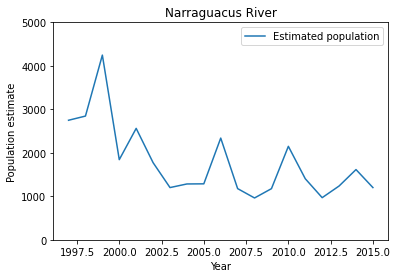

In [6]:
def plot_population(series):
    series.plot(label='Estimated population', xlabel='Year', 
             ylabel='Population estimate', 
             title='Narraguacus River',
             legend=True,
             ylim=[0, 5000])
    
plot_population(pop_series)

## Modeling changes

To see how the population changes from year-to-year, I'll use `diff` to compute the absolute difference between each year and the next: in other words, to determine how much the population grows or shrinks in that year.

The default setting for `diff` is to find the difference with the previous row.  But since we want to find the percent change in the population, we want to compare the change in population to the size of the population in the previous year.  So we use the setting `periods=-1`, which tells the function to find the difference with the following row. See https://pandas.pydata.org/docs/reference/api/pandas.Series.diff.html.


In [7]:
abs_diffs = -pop_series.diff(periods=-1)
abs_diffs

1997      96.0
1998    1402.0
1999   -2404.0
2000     719.0
2001    -788.0
2002    -573.0
2003      83.0
2004       3.0
2005    1052.0
2006   -1162.0
2007    -215.0
2008     214.0
2009     973.0
2010    -745.0
2011    -435.0
2012     268.0
2013     378.0
2014    -414.0
2015       NaN
dtype: float64

We can compute relative differences by dividing by the original series elementwise.

In [8]:
rel_diffs = abs_diffs / pop_series
rel_diffs

1997    0.034922
1998    0.492794
1999   -0.566047
2000    0.390125
2001   -0.307572
2002   -0.322999
2003    0.069109
2004    0.002336
2005    0.817405
2006   -0.496794
2007   -0.182668
2008    0.222453
2009    0.827381
2010   -0.346673
2011   -0.309829
2012    0.276574
2013    0.305578
2014   -0.256347
2015         NaN
dtype: float64

These relative differences are observed annual net growth rates.  So let's drop the `NaN` and save them.

In [9]:
rates = rel_diffs.dropna()
rates

1997    0.034922
1998    0.492794
1999   -0.566047
2000    0.390125
2001   -0.307572
2002   -0.322999
2003    0.069109
2004    0.002336
2005    0.817405
2006   -0.496794
2007   -0.182668
2008    0.222453
2009    0.827381
2010   -0.346673
2011   -0.309829
2012    0.276574
2013    0.305578
2014   -0.256347
dtype: float64

A simple way to model this system is to draw a random value from this series of observed rates each year.  We can use the NumPy function `choice` to make a random choice from a series.

The assumption here is that the values as a whole are not changing with time (the river is not getting more or less healthy with time, for instance), and there is no pattern to the population changes.

In [10]:
np.random.choice(rates)

0.8174048174048174

## Simulation

Now we can simulate the system by drawing random growth rates from the series of observed rates.

I'll start the simulation in 2015.

In [11]:
t_0 = 2015
p_0 = pop_series[t_0]

I'll create a system object with variables `t_0`, `p_0`, `rates`, and `duration=10` years. 

The series of observed rates is one big parameter of the model.

In [12]:
system = dict(t_0=t_0,
                p_0=p_0,
                duration=10,
                rates=rates)

Write an change function that takes as parameters `pop`, `t`, and `system`.
It should choose a random growth rate, compute the change in population, and return the new population.  

In [13]:
# Write update_func function
def change_func(pop,t,system):
    rate = np.random.choice(rates)
    pop = pop*rate + pop
    return pop
        

Test your change function and run it a few times

In [14]:
change_func(p_0, t_0, system)

2194.684523809524

Here's a version of `run_simulation` that stores the results in a `Series` and returns it.

In [15]:
def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    t_0 = system['t_0']
    t_end = t_0 + system['duration']
    
    results = pd.Series([],dtype=object)
    results[t_0] = system['p_0']
    
    for t in np.arange(t_0, t_end+1,1):
        results[t+1] = update_func(results[t], t, system)
    return results

Use `run_simulation` to run generate a prediction for the next 10 years.

The plot your prediction along with the original data.  Your prediction should pick up where the data leave off.

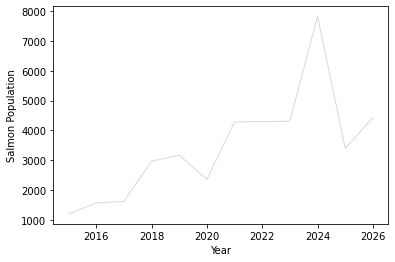

In [16]:
# Plot the prediction here
results = run_simulation(system,change_func)

results.plot(color='gray', label='_nolegend', 
                     linewidth=1, alpha=0.3,
                    xlabel='Year',ylabel='Salmon Population');

To get a sense of how much the results vary, we can run the model several times and plot all of the results.

In [17]:
def plot_many_simulations(system, change_func, iters):
    """Runs simulations and plots the results.
    
    system: System object
    update_func: function object
    iters: number of simulations to run
    """
    for i in range(iters):
        results = run_simulation(system, change_func)
        results.plot(color='gray', label='_nolegend', 
                     linewidth=1, alpha=0.3,
                    xlabel='Year',ylabel='Salmon Population');

The plot option `alpha=0.1` makes the lines semi-transparent, so they are darker where they overlap.

Run `plot_many_simulations` with your update function and `iters=30`.  Also plot the original data (from 1997 to 2015) on the same graph.

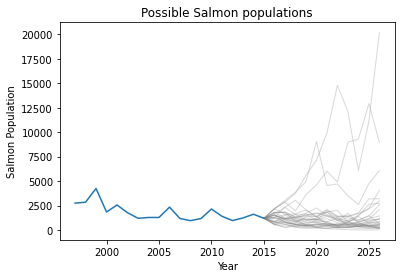

In [18]:
# Plot the data over many simulations
plot_many_simulations(system,change_func,30)
pop_series.plot(title='Possible Salmon populations');

The results are highly variable: according to this model, the population might continue to decline over the next 10 years, or it might recover and grow rapidly!

It's hard to say how seriously we should take this model.  There are many factors that influence salmon populations that are not included in the model.  For example, if the population starts to grow quickly, it might be limited by resource limits, predators, or fishing.  If the population starts to fall, humans might restrict fishing and stock the river with farmed fish.

So these results should probably not be considered useful predictions.  However, there might be something useful we can do, which is to estimate the probability that the population will increase or decrease in the next 10 years.  

## Distribution of net changes

To describe the distribution of net changes, write a function called `run_many_simulations` that runs many simulations, saves the results.  Save the final results in a `Series` and return the `Series`.

To access the last value in the results `Series`, you'll need to find `t_end` (similarly to the way it is defined in `run_simulation`).


In [19]:
def run_many_simulations(system, change_func, iters):
    """Runs simulations and report final populations.
    
    system: system dictionary
    update_func: function object
    iters: number of simulations to run
    
    returns: series of final populations
    """
    #  Fill in below 
    series = pd.Series([],dtype=object)
    for i in range(iters):
        results = run_simulation(system, change_func)
        t_end = system['t_0'] + system['duration'] + 1
        series[i] = results[t_end]
    
    return series
        

Test your function by running it with `iters=5`.

In [20]:
results = run_many_simulations(system, change_func, 5)
results

0    1315.247299
1    1154.524440
2     412.746556
3     947.134766
4    1957.929381
dtype: float64

Now we can run 1000 simulations and describe the distribution of the results.

In [21]:
last_pops = run_many_simulations(system, change_func, 1000)
last_pops.describe()

count     1000.000000
mean      1677.814885
std       3449.444960
min         10.810128
25%        282.008609
50%        714.112871
75%       1694.236701
max      56123.205279
dtype: float64

If we substract off the initial population, we get the distribution of changes.

In [22]:
net_changes = last_pops - p_0
net_changes.describe()

count     1000.000000
mean       476.814885
std       3449.444960
min      -1190.189872
25%       -918.991391
50%       -486.887129
75%        493.236701
max      54922.205279
dtype: float64

The median is negative, which indicates that the population decreases more often than it increases.  However, the mean might be positive, which suggests that there are enough very large growth situations to balance out the large number of shrunken populations.

We can be more specific by counting the number of runs where `net_changes` is positive.

In [23]:
np.sum(net_changes > 0)

341

Or we can use `mean` to compute the fraction of runs where `net_changes` is positive.

In [24]:
np.mean(net_changes > 0)

0.341

And here's the fraction where it's negative.

In [25]:
np.mean(net_changes < 0)

0.659

So, based on observed past changes, this model predicts that the population is more likely to decrease than increase over the next 10 years, by about 2:1.  You might try running it again: is 1000 simulations enough to get a dependable result?

## A refined model

There are a few ways we could improve the model.

1.  It looks like there might be cyclic behavior in the past data, with a period of 4-5 years.  We could extend the model to include this effect.

2.  Older data might not be as relevant for prediction as newer data, so we could give more weight to newer data.

The second option is easier to implement, so let's try it.

I'll use `linspace` to create an array of "weights" for the observed rates.  The probability that I choose each rate will be proportional to these weights.

The weights have to add up to 1, so I divide through by the total using the `/=` tool (this divides all the elements in the array by a value, which in this case is the sum of the array, just as `+=` adds a value to a variable).

In [26]:
weights = linspace(0, 1, len(rates))
weights /= sum(weights)   # This is the same as: weights = weights/sum(weights)
weights

array([0.        , 0.00653595, 0.0130719 , 0.01960784, 0.02614379,
       0.03267974, 0.03921569, 0.04575163, 0.05228758, 0.05882353,
       0.06535948, 0.07189542, 0.07843137, 0.08496732, 0.09150327,
       0.09803922, 0.10457516, 0.11111111])

I'll add the weights to the system object, since they are parameters of the model.

In [27]:
system['weights'] = weights

We can pass these weights as a parameter to `np.random.choice` (see the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)).  In effect, this makes it more likely that the rates associated with the later dates will be chosen.

In [28]:
np.random.choice(system['rates'], p=system['weights'])

-0.2563467492260062

Write an update function that takes the weights into account.

In [29]:
# Write a weighted update_func function
def change_func_weighted(pop,t,system):
    rate = np.random.choice(system['rates'],p=system['weights'])
    pop = pop*rate + pop
    return pop
        

Use `plot_many_simulations` to plot the results.

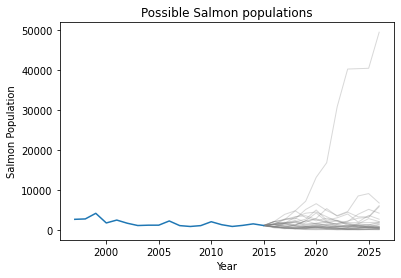

In [30]:
# Plot the data over many simulations
plot_many_simulations(system,change_func_weighted,30)
pop_series.plot(title='Possible Salmon populations');

Use `run_many_simulations` to collect the results and `describe` to summarize the distribution of net changes.

In [31]:
# Use run_many_simulations
last_pops = run_many_simulations(system, change_func_weighted, 1000)
net_changes = last_pops - p_0
net_changes.describe()

count     1000.000000
mean       552.372270
std       2807.196318
min      -1180.597890
25%       -832.697538
50%       -397.402629
75%        791.133602
max      34825.683250
dtype: float64

Does the refined model have much effect on the probability of population decline?

In [32]:
np.mean(net_changes < 0)

0.616